In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Import q_stats

In [2]:
qstats=pd.read_csv('../data/qstats_for_M1')
qstats

,Unnamed: 0,content_id,bundle_id,correct_answer,part,tags,qstats_count,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation
0,0,0,0,0,1,51 131 162 38,6903,0.907721,0.948138,0.911994,0.829609
1,1,1,1,1,1,131 36 81,7398,0.890646,0.980400,0.892183,0.813793
2,2,2,2,0,1,131 101 162 92,44905,0.554281,0.888253,0.562213,0.491232
3,3,3,3,0,1,131 149 162 29,22973,0.779437,0.958473,0.783460,0.686583
4,4,4,4,3,1,131 5 162 38,31736,0.613215,0.530313,0.654308,0.566819
...,...,...,...,...,...,...,...,...,...,...,...
13518,13518,13518,13518,3,5,14,868,0.786866,0.998848,0.786621,1.000000
13519,13519,13519,13519,3,5,8,924,0.571429,0.994589,0.570185,0.800000
13520,13520,13520,13520,2,5,73,861,0.672474,0.995354,0.670945,1.000000
13521,13521,13521,13521,0,5,125,870,0.808046,0.996552,0.808535,0.666667


# Model import

In [3]:
import pickle
my_pipeline = pickle.load(open('../models/xgboost_pipe_M1.pkl',"rb"))  ## wb= write bites : le b est important

In [4]:
pipeline_features_list=pd.read_csv('../models/xgboost_pipe_M1_features_list')

In [5]:
[pipeline_features_list.feature.to_list()]

[['user_personalized_qstat_knowing_had_explanation_or_not',
  'user_avg_score_cum_on_this_part',
  'user_correct_answers_cum_on_this_part',
  'qstats_answered_correctly',
  'user_avg_score_cum',
  'qstats_prior_question_had_explanation',
  'already_seen',
  'user_activity_cumcount',
  'at_least_one_lesson']]

# Initialisation utilisateur débutant

In [6]:
user_history_empty=pd.DataFrame({#following columns are the impute of each loop
                             ### TO BE IMPUTED ###
                             'content_id':[-1],
                             'content_type_id':[-1],
                             'prior_question_had_explanation':False,
                             # following columns depend of previous history of the user : 
                             ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
                             'user_activity_cumcount':[-1],
                             'at_least_one_lesson':[0],
                             ### TO BE UPDATED IF LAST WAS QUESTION , ELSE COPIED ###
                             'user_avg_score_cum':[0.499],
                             'user_correct_answers_cum':[0],
                             'user_avg_score_cum_part1':[0.499],
                             'user_avg_score_cum_part2':[0.499],
                             'user_avg_score_cum_part3':[0.499],
                             'user_avg_score_cum_part4':[0.499],
                             'user_avg_score_cum_part5':[0.499],
                             'user_avg_score_cum_part6':[0.499],
                             'user_avg_score_cum_part7':[0.499],
                             'user_correct_answers_cum_part1':[0],
                             'user_correct_answers_cum_part2':[0],
                             'user_correct_answers_cum_part3':[0],
                             'user_correct_answers_cum_part4':[0],
                             'user_correct_answers_cum_part5':[0],
                             'user_correct_answers_cum_part6':[0],
                             'user_correct_answers_cum_part7':[0],
                             # following columns are pure question stats : 
                             ### TO BE IMPORTED ###
                             'part':[-1],
                             'qstats_answered_correctly':[-1],
                             'qstats_prior_question_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_not_had_explanation':[-1],
                             # following columns depend of the current question AND the hisory of user
                             ### TO BE COMPUTED ###
                             'user_personalized_qstat_knowing_had_explanation_or_not':[-1],
                             'already_seen':[-1],
                             'user_avg_score_cum_on_this_part':[-1],
                             'user_correct_answers_cum_on_this_part':[-1],
                             # the following line is the prediction to be made
                             ### TO BE PREDICTED ###
                             'answered_correctly':[-1]
                          })

# User history step

## Update function

In [36]:
def user_history_update(content_type_id,
                        content_id,
                        data_qstats,
                        user_history=None,
                        mode='training',    #autre choix : mode exam
                        prior_question_had_explanation=False):
    '''Crée ou met à jour l'hisorique d'un utilisateur, stockée dans un df'''

    if not type(user_history)==pd.DataFrame:
        user_history=pd.DataFrame({
                             #following columns are the impute of each loop
                             ### TO BE IMPUTED ###
                             'content_id':[-1],
                             'content_type_id':[-1],
                             'prior_question_had_explanation':False,
                             'mode':'n/a',
                             # following columns depend of previous history of the user : 
                             ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
                             'user_activity_cumcount':[-1],
                             ### TO BE UPDATED IF LAST WAS LECTURE ###
                             'at_least_one_lesson':[0],
                             ### TO BE UPDATED IF LAST WAS QUESTION ###
                             'user_avg_score_cum':[0.499],
                             'user_correct_answers_cum':[0],
                             'user_avg_score_cum_part1':[0.499],
                             'user_avg_score_cum_part2':[0.499],
                             'user_avg_score_cum_part3':[0.499],
                             'user_avg_score_cum_part4':[0.499],
                             'user_avg_score_cum_part5':[0.499],
                             'user_avg_score_cum_part6':[0.499],
                             'user_avg_score_cum_part7':[0.499],
                             'user_correct_answers_cum_part1':[0],
                             'user_correct_answers_cum_part2':[0],
                             'user_correct_answers_cum_part3':[0],
                             'user_correct_answers_cum_part4':[0],
                             'user_correct_answers_cum_part5':[0],
                             'user_correct_answers_cum_part6':[0],
                             'user_correct_answers_cum_part7':[0],
                             # following columns are pure question stats : 
                             ### TO BE IMPORTED FROM QUESTIONS ###
                             'part':[-1],
                             'qstats_answered_correctly':[-1],
                             'qstats_prior_question_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_not_had_explanation':[-1],
                             # following columns depend of the current question AND the hisory of user
                             ### TO BE COMPUTED ###
                             'user_personalized_qstat_knowing_had_explanation_or_not':[-1],
                             'already_seen':[-1],
                             'user_avg_score_cum_on_this_part':[-1],
                             'user_correct_answers_cum_on_this_part':[-1],
                             # the following line is the prediction to be made
                             ### TO BE PREDICTED ###
                             'answered_correctly':[-1]
                          })
    

    last_line=user_history.iloc[-1]
    new_line =last_line.copy()
    
    last_content_type_id=user_history.iloc[-1]['content_type_id']
    
    ### TO BE IMPUTED ###
    new_line['content_id']=content_id
    new_line['content_type_id']=content_type_id
    new_line['prior_question_had_explanation']=prior_question_had_explanation
    new_line['mode']=mode
    ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
    new_line['user_activity_cumcount'] += 1
    
    if mode=='training':
        if last_content_type_id==0:
            part=last_line['part']
            ### TO BE UPDATED IF LAST WAS QUESTION ###
            new_line['user_correct_answers_cum'] = last_line['user_correct_answers_cum']\
                                                 + last_line['answered_correctly']
            new_user_questions_count             = last_line['user_correct_answers_cum']\
                                                 / (last_line['user_avg_score_cum']+0.000001)\
                                                 + 1
            new_line['user_avg_score_cum']       = new_line['user_correct_answers_cum']\
                                                 / new_user_questions_count

            new_line[f'user_correct_answers_cum_part{part}'] = last_line[f'user_correct_answers_cum_part{part}']\
                                                             + last_line['answered_correctly']
            vars()[f'new_user_questions_count_part{part}']   = last_line[f'user_correct_answers_cum_part{part}']\
                                                             / last_line[f'user_avg_score_cum_part{part}']\
                                                             + 1
            new_line[f'user_avg_score_cum_part{part}']       = new_line[f'user_correct_answers_cum_part{part}']\
                                                             / vars()[f'new_user_questions_count_part{part}']

        elif last_content_type_id==1:
            ### TO BE UPDATED IF LAST WAS LECTURE ###
            new_line['at_least_one_lesson']=1
        
    if content_type_id==0:        
        currect_question_stats=qstats.loc[qstats.content_id==content_id].iloc[-1]
        ### TO BE IMPORTED FROM QUESTIONS ###
        new_line['part']\
              = currect_question_stats['part']
        new_line['qstats_answered_correctly']\
              = currect_question_stats['qstats_answered_correctly']
        new_line['qstats_prior_question_had_explanation']\
              = currect_question_stats['qstats_prior_question_had_explanation']
        new_line['qstats_answered_correctly_knowing_having_had_explanation']\
              = currect_question_stats['qstats_answered_correctly_knowing_having_had_explanation']
        new_line['qstats_answered_correctly_knowing_having_not_had_explanation']\
              = currect_question_stats['qstats_answered_correctly_knowing_having_not_had_explanation']
        ### TO BE COMPUTED ###
        new_line['user_personalized_qstat_knowing_had_explanation_or_not']\
              = new_line['qstats_answered_correctly_knowing_having_had_explanation']\
             if prior_question_had_explanation\
           else new_line['qstats_answered_correctly_knowing_having_not_had_explanation']
        new_line['already_seen']\
              = 1 if content_id in user_history.loc[user_history.content_type_id==0,'content_id']\
           else 0
        new_line['user_avg_score_cum_on_this_part']=new_line[f'user_avg_score_cum_part{new_line["part"]}']
        new_line['user_correct_answers_cum_on_this_part']=new_line[f'user_correct_answers_cum_part{new_line["part"]}']
                                              
    elif content_type_id==1:
        
        ### TO BE IMPORTED ###
        new_line['part']= -1 # TODO : si on veut utiliser la partie de la lecture, il faut importer la base des lectures
        new_line['qstats_answered_correctly']= -1
        new_line['qstats_prior_question_had_explanation']= -1
        new_line['qstats_answered_correctly_knowing_having_had_explanation']= -1
        new_line['qstats_answered_correctly_knowing_having_not_had_explanation']= -1
        ### TO BE COMPUTED ###
        new_line['user_personalized_qstat_knowing_had_explanation_or_not']= -1
        new_line['already_seen']= -1
        new_line['user_avg_score_cum_on_this_part']= -1
        new_line['user_correct_answers_cum_on_this_part']= -1
        
    ### TO BE PREDICTED ###
    new_line['answered_correctly']= -1
                                
    user_history=user_history.append(new_line,ignore_index=True)

    return user_history

## Test de la fonction

In [20]:
user_history=user_history_update(0, #content_type_id=0 <=> question
                                 13522, #numéro d'une question au hasard
                                 qstats, #df des stats questions
                                 user_history=None, #None pour une utilisateur nouveau
                                 prior_question_had_explanation=False, #
                                )
user_history.iloc[-1,-1]=0.8
user_history

,content_id,content_type_id,prior_question_had_explanation,mode,user_activity_cumcount,at_least_one_lesson,user_avg_score_cum,user_correct_answers_cum,user_avg_score_cum_part1,user_avg_score_cum_part2,...,part,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation,user_personalized_qstat_knowing_had_explanation_or_not,already_seen,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,answered_correctly
0,-1,-1,False,n/a,-1,0,0.499,0,0.499,0.499,...,-1,-1.000000,-1.00000,-1.000000,-1.0,-1.0,-1,-1.000,-1,-1.0
1,13522,0,False,training,0,0,0.499,0,0.499,0.499,...,5,0.913953,0.99186,0.913247,1.0,1.0,0,0.499,0,0.8


In [21]:
user_history=user_history_update(0,13521,qstats,user_history,prior_question_had_explanation=False)
user_history

,content_id,content_type_id,prior_question_had_explanation,mode,user_activity_cumcount,at_least_one_lesson,user_avg_score_cum,user_correct_answers_cum,user_avg_score_cum_part1,user_avg_score_cum_part2,...,part,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation,user_personalized_qstat_knowing_had_explanation_or_not,already_seen,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,answered_correctly
0,-1,-1,False,n/a,-1,0,0.499,0.0,0.499,0.499,...,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1.000,-1.0,-1.0
1,13522,0,False,training,0,0,0.499,0.0,0.499,0.499,...,5,0.913953,0.991860,0.913247,1.000000,1.000000,0,0.499,0.0,0.8
2,13521,0,False,training,1,0,0.800,0.8,0.499,0.499,...,5,0.808046,0.996552,0.808535,0.666667,0.666667,0,0.800,0.8,-1.0


## Loop

In [33]:
loop_length=100
question_selection_strategy='random'

import random

### Initialize the user to None or starting level ###
user_history=None

for i in range(loop_length):
    ### CHOIX DE LA QUESTION ###
    if question_selection_strategy=='random':
        next_question_id=random.choice(qstats.content_id.to_list())
    
    
    user_history=user_history_update(0,
                                     next_question_id,
                                     qstats,
                                     user_history,
                                     mode='training',
                                     prior_question_had_explanation=random.uniform(0, 1)>0.1)
    
    ### PREDICTION ###
    user_history.iloc[-1,-1]\
        = my_pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-2:-1])[0,1]
user_history
    

,content_id,content_type_id,prior_question_had_explanation,mode,user_activity_cumcount,at_least_one_lesson,user_avg_score_cum,user_correct_answers_cum,user_avg_score_cum_part1,user_avg_score_cum_part2,...,part,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation,user_personalized_qstat_knowing_had_explanation_or_not,already_seen,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,answered_correctly
0,-1,-1,False,n/a,-1,0,0.499000,0.000000,0.499000,0.499000,...,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1.000000,-1.000000,-1.000000
1,10156,0,True,training,0,0,0.499000,0.000000,0.499000,0.499000,...,6,0.935778,0.964371,0.934803,0.962185,0.934803,0,0.499000,0.000000,0.070943
2,7256,0,True,training,1,0,0.070943,0.070943,0.499000,0.499000,...,7,0.939275,0.955876,0.936472,1.000000,0.936472,0,0.499000,0.000000,0.897830
3,12280,0,True,training,2,0,0.484386,0.968773,0.499000,0.499000,...,3,0.900794,0.980159,0.898785,1.000000,0.898785,0,0.499000,0.000000,0.866527
4,5319,0,True,training,3,0,0.611767,1.835300,0.499000,0.499000,...,5,0.753854,0.324473,0.831240,0.716684,0.831240,0,0.499000,0.000000,0.857180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1983,0,False,training,95,0,0.689225,65.476328,0.755667,0.622827,...,3,0.681965,0.968469,0.682068,0.678815,0.678815,0,0.672725,7.399975,0.796632
97,2274,0,True,training,96,0,0.690343,66.272960,0.755667,0.622827,...,3,0.641673,0.971992,0.640651,0.677130,0.640651,0,0.683051,8.196607,0.698220
98,4186,0,True,training,97,0,0.690425,66.971180,0.755667,0.622827,...,5,0.948855,0.942748,0.953036,0.880000,0.953036,0,0.721749,30.313461,0.672461
99,4575,0,True,training,98,0,0.690241,67.643641,0.755667,0.622827,...,5,0.771135,0.851495,0.797282,0.621212,0.797282,0,0.720603,30.985922,0.976701


# Looping functions

## Training

In [13]:
def training (my_pipeline,
              pipeline_features_list,
              qstats,
              user_history=None,
              loop_length=30,
              question_selection_strategy='random'):
    '''only the random strategy implemented yet'''
    for i in range(loop_length):
        ### CHOIX DE LA QUESTION ###
        if question_selection_strategy=='random':
            next_question_id=random.choice(qstats.content_id.to_list())


            user_history=user_history_update(0,
                                         next_question_id,
                                         qstats,
                                         user_history,
                                         mode='training',
                                         prior_question_had_explanation=random.uniform(0, 1)>0.1)

        ### PREDICTION ###
            user_history.iloc[-1,-1]\
                = my_pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-2:-1])[0,1]
    return user_history

## Final exam

In [28]:
def TOEIC_scoring (my_pipeline,
                   pipeline_features_list,
                   qstats, user_history,
                   number_of_questions=100,
                   TOEIC_strategy='random'):
    '''only the random strategy implemented yet'''
    
    for i in range(number_of_questions):
        ### CHOIX DE LA QUESTION ###
        if TOEIC_strategy=='random':
            next_question_id=random.choice(qstats.content_id.to_list())


        user_history=user_history_update(0,
                                         next_question_id,
                                         qstats,
                                         user_history,
                                         mode='exam',
                                         prior_question_had_explanation=False)

        ### PREDICTION ###
        user_history.iloc[-1,-1]\
            = my_pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-2:-1])[0,1]
    
    return user_history.iloc[-number_of_questions:].answered_correctly.mean()

In [34]:
TOEIC_scoring(qstats, user_history)

0.7035000891559166

In [36]:
user_history=None
TOEIC_scoring(qstats, user_history)

0.5785637135444083

# Profiles initialization

In [4]:
df = pd.read_csv('../data/train_1M_with_features_merged_v3.csv')

In [16]:
df

,Unnamed: 0,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,part2,part3,part4,part5,part6,part7,already_seen_tag_q_l_cumcount_with_trim_at_3,same_user_and_similar_to_prior,similar_to_prior_and_had_answered_correctly,similar_to_prior_and_have_had_explanation
0,0,90286654,0,1917429896,7900,0,0,1,NaN,0,...,0,0,0,0,0,0,0,0.0,-0.0,0.0
1,1,90286655,26511,1917429896,7876,0,1,0,21000.0,0,...,0,0,0,0,0,0,0,0.5,0.5,0.0
2,2,90286656,55312,1917429896,175,0,2,0,21000.0,0,...,0,0,0,0,0,0,0,0.5,0.0,0.0
3,3,90286657,102436,1917429896,1278,0,3,0,23000.0,0,...,1,0,0,0,0,0,0,0.0,0.0,0.0
4,4,90286658,188454,1917429896,2063,0,4,0,45000.0,0,...,0,1,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987264,987264,47484293,1619704,1003849974,6909,0,14,1,17000.0,0,...,0,0,0,0,1,0,0,0.5,0.5,0.0
987265,987265,47484294,1906094,1003849974,7217,0,15,1,68500.0,0,...,0,0,0,0,0,1,0,0.0,0.0,0.0
987266,987266,47484295,1906094,1003849974,7216,0,15,1,68500.0,0,...,0,0,0,0,0,1,0,0.5,0.5,0.0
987267,987267,47484296,1906094,1003849974,7219,0,15,1,68500.0,0,...,0,0,0,0,0,1,0,0.5,0.5,0.0


In [20]:
part1_mean_perf=df.query('content_type_id==0').query('part1==1').mean()['answered_correctly']
part2_mean_perf=df.query('content_type_id==0').query('part2==1').mean()['answered_correctly']
part3_mean_perf=df.query('content_type_id==0').query('part3==1').mean()['answered_correctly']
part4_mean_perf=df.query('content_type_id==0').query('part4==1').mean()['answered_correctly']
part5_mean_perf=df.query('content_type_id==0').query('part5==1').mean()['answered_correctly']
part6_mean_perf=df.query('content_type_id==0').query('part6==1').mean()['answered_correctly']
part7_mean_perf=df.query('content_type_id==0').query('part7==1').mean()['answered_correctly']

In [31]:
parts_mean_correct_count=[]
parts_max_correct_count=[]
for i in range(7):
    parts_mean_correct_count.append(df.query('content_type_id==0')\
                                    .query(f'part{i+1}==1')\
                                    .groupby('user_id')\
                                    .sum()['answered_correctly']\
                                    .mean())
    parts_max_correct_count.append(df.query('content_type_id==0')\
                                   .query(f'part{i+1}==1')\
                                   .groupby('user_id')\
                                   .sum()['answered_correctly']\
                                   .max())

In [34]:
parts_max_correct_count

[689, 2653, 1247, 981, 3561, 1363, 1012]

In [26]:
parts_mean_perfs=[]
for i in range(7):
    parts_mean_perfs.append([vars()[f'part{i+1}_mean_perf']])
parts_mean_perfs

[[0.7394397023418691],
 [0.7107757984490843],
 [0.6947983774755428],
 [0.6184897300138936],
 [0.6121735463434248],
 [0.6767750892502975],
 [0.6657133571660708]]

In [27]:
[lis[0] for lis in parts_mean_perfs]

[0.7394397023418691,
 0.7107757984490843,
 0.6947983774755428,
 0.6184897300138936,
 0.6121735463434248,
 0.6767750892502975,
 0.6657133571660708]

In [8]:
def initialize_profile(experience_list):
    '''Takes a list of 7 values, one per part
            0=full beginner,
            1=intermediate,
            2=average,
            3=fluent
            exemple : [0,1,1,3,1,2,0]
            
        Returns a one-line user_history 
        with the average and cumulated score per part initialized
            '''
    parts_mean_perfs=[0.7394,
                      0.7107,
                      0.6947,
                      0.6184,
                      0.6121,
                      0.6767,
                      0.6657]
    
    parts_mean_correct_count=[18.8,
                              35.0,
                              27.4,
                              24.3,
                              65.2,
                              32.6,
                              16.1]
    parts_max_correct_count=[689,
                             2653,
                             1247,
                             981,
                             3561,
                             1363,
                             1012]     
    
    user_avg_score_cum_parts=[]
    user_correct_answers_cum_parts=[]
    for i in range(7):
        if experience_list[i]==0:
            user_avg_score_cum_parts.append(0)
            user_correct_answers_cum_parts.append(0)
            at_least_one_lesson=0
        if experience_list[i]==1:
            user_avg_score_cum_parts.append(parts_mean_perfs[i]/2)
            user_correct_answers_cum_parts.append(parts_mean_correct_count[i]/2)
            at_least_one_lesson=0
        if experience_list[i]==2:
            user_avg_score_cum_parts.append(parts_mean_perfs[i])
            user_correct_answers_cum_parts.append(parts_mean_correct_count[i])
            at_least_one_lesson=1
        if experience_list[i]==3:
            user_avg_score_cum_parts.append(1)
            user_correct_answers_cum_parts.append(parts_max_correct_count[i])
            at_least_one_lesson=1
            
    user_correct_answers_cum=sum(user_correct_answers_cum_parts)
    user_avg_score_cum=user_correct_answers_cum\
                       /(sum([user_correct_answers_cum_parts[i]\
                              /(user_avg_score_cum_parts[i]+0.000001) for i in range(7)])+0.000001)
            
            
    user_profile=pd.DataFrame({
                             #following columns are the impute of each loop
                             ### TO BE IMPUTED ###
                             'content_id':[-1],
                             'content_type_id':[-1],
                             'prior_question_had_explanation':False,
                             'mode':'n/a',
                             # following columns depend of previous history of the user : 
                             ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
                             'user_activity_cumcount':[-1],
                             ### TO BE UPDATED IF LAST WAS LECTURE ###
                             'at_least_one_lesson':[at_least_one_lesson],
                             ### TO BE UPDATED IF LAST WAS QUESTION ###
                             'user_avg_score_cum':[user_avg_score_cum],
                             'user_correct_answers_cum':[user_correct_answers_cum],
                             'user_avg_score_cum_part1':[user_avg_score_cum_parts[0]],
                             'user_avg_score_cum_part2':[user_avg_score_cum_parts[1]],
                             'user_avg_score_cum_part3':[user_avg_score_cum_parts[2]],
                             'user_avg_score_cum_part4':[user_avg_score_cum_parts[3]],
                             'user_avg_score_cum_part5':[user_avg_score_cum_parts[4]],
                             'user_avg_score_cum_part6':[user_avg_score_cum_parts[5]],
                             'user_avg_score_cum_part7':[user_avg_score_cum_parts[6]],
                             'user_correct_answers_cum_part1':[user_correct_answers_cum_parts[0]],
                             'user_correct_answers_cum_part2':[user_correct_answers_cum_parts[1]],
                             'user_correct_answers_cum_part3':[user_correct_answers_cum_parts[2]],
                             'user_correct_answers_cum_part4':[user_correct_answers_cum_parts[3]],
                             'user_correct_answers_cum_part5':[user_correct_answers_cum_parts[4]],
                             'user_correct_answers_cum_part6':[user_correct_answers_cum_parts[5]],
                             'user_correct_answers_cum_part7':[user_correct_answers_cum_parts[6]],
                             # following columns are pure question stats : 
                             ### TO BE IMPORTED FROM QUESTIONS ###
                             'part':[-1],
                             'qstats_answered_correctly':[-1],
                             'qstats_prior_question_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_not_had_explanation':[-1],
                             # following columns depend of the current question AND the hisory of user
                             ### TO BE COMPUTED ###
                             'user_personalized_qstat_knowing_had_explanation_or_not':[-1],
                             'already_seen':[-1],
                             'user_avg_score_cum_on_this_part':[-1],
                             'user_correct_answers_cum_on_this_part':[-1],
                             # the following line is the prediction to be made
                             ### TO BE PREDICTED ###
                             'answered_correctly':[-1]
                          })
    return user_profile

In [5]:
initialize_profile([0,3,0,0,3,0,0]).loc[0]

content_id                                                         -1
content_type_id                                                    -1
prior_question_had_explanation                                  False
mode                                                              n/a
user_activity_cumcount                                             -1
at_least_one_lesson                                                 0
user_avg_score_cum                                                  1
user_correct_answers_cum                                         6214
user_avg_score_cum_part1                                            0
user_avg_score_cum_part2                                            1
user_avg_score_cum_part3                                            0
user_avg_score_cum_part4                                            0
user_avg_score_cum_part5                                            1
user_avg_score_cum_part6                                            0
user_avg_score_cum_p

# Scoring de la méthode aléatoire

In [37]:
def plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=5,
                        training_batch_size=10,
                        number_of_training_batches=10,
                        training_question_selection_strategy='random')
    result_moy=[]

    for i in range(number_students):
        print(f'début essai {i+1}/{number_students}')
        results=[]
        training_questions=[]

        user_history=user_initial_state
        results.append(TOEIC_scoring(qstats, user_history))
        training_questions.append(0)

        for j in range(number_of_training_batches):
            training_questions.append(training_questions[-1]+training_batch_size)
            print(f'entrainement {j*training_batch_size}/{20*5}')

            user_history=training (my_pipeline,
                                   pipeline_features_list,qstats,
                                   user_history,
                                   loop_length=training_batch_size,
                                   question_selection_strategy=training_question_selection_strategy)
            results.append(TOEIC_scoring(my_pipeline,
                                         pipeline_features_list,
                                         qstats, 
                                         user_history))

        result_moy.append(results)
    stats=np.array(result_moy)
    plt.plot(training_questions,stats.mean(axis=0))

début essai 1/5
entrainement 0/100
entrainement 10/100
entrainement 20/100
entrainement 30/100
entrainement 40/100
entrainement 50/100
entrainement 60/100
entrainement 70/100
entrainement 80/100
entrainement 90/100
début essai 2/5
entrainement 0/100
entrainement 10/100
entrainement 20/100
entrainement 30/100
entrainement 40/100
entrainement 50/100
entrainement 60/100
entrainement 70/100
entrainement 80/100
entrainement 90/100
début essai 3/5
entrainement 0/100
entrainement 10/100
entrainement 20/100
entrainement 30/100
entrainement 40/100
entrainement 50/100
entrainement 60/100
entrainement 70/100
entrainement 80/100
entrainement 90/100
début essai 4/5
entrainement 0/100
entrainement 10/100
entrainement 20/100
entrainement 30/100
entrainement 40/100
entrainement 50/100
entrainement 60/100
entrainement 70/100
entrainement 80/100
entrainement 90/100
début essai 5/5
entrainement 0/100
entrainement 10/100
entrainement 20/100
entrainement 30/100
entrainement 40/100
entrainement 50/100
entra

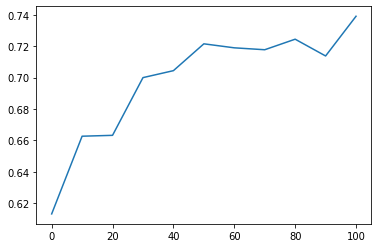

In [38]:
stats=np.array(result_moy)
plt.plot(training_questions,stats.mean(axis=0))

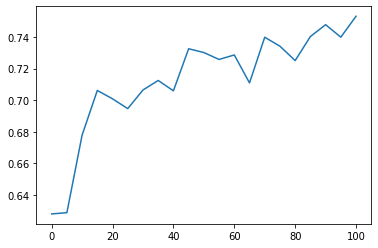

# Import des fonctions py

In [6]:
from tm_loop_functions import *

In [8]:
plot_learning_curve(my_pipeline,
                        pipeline_features_list,
                        qstats,
                        initial_experience=[0,0,0,0,0,0,0],
                        number_students=2,
                        training_batch_size=5,
                        number_of_training_batches=5,
                        training_question_selection_strategy='random')

début essai 1/2
entrainement 0/25
entrainement 5/25
entrainement 10/25
entrainement 15/25
entrainement 20/25
début essai 2/2
entrainement 0/25
entrainement 5/25
entrainement 10/25
entrainement 15/25
entrainement 20/25


,TOEIC_score
training_questions,
0,0.446822
5,0.562323
10,0.601080
15,0.578349
20,0.623570
25,0.633240
